## NREL National Solar Radiation Database (NSRDB) - HSDS Demo

This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

For this to work you must first install h5pyd:

```
pip install --user h5pyd
```

Next you'll need to configure HSDS:

```
hsconfigure
```

and enter at the prompt:

```
hs_endpoint = https://developer.nrel.gov/api/hsds
hs_username = None
hs_password = None
hs_api_key = CLN7qg8PRpaqkkeS9STW3BvCMvh81m4UYopmVoOf
```

You can also add the above contents to a configuration file at ~/.hscfg

In [38]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree

## Basic Usage

The NSRDB is provided in annual .h5 files and currently spans 1998-2018.  
Each year can be accessed from /nrel/nsrdb/nsrdb_${year}.h5

In [39]:
# Open the desired year of nsrdb data
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2020.h5", 'r')

In [40]:
list(f.attrs)  # list attributes belonging to the root group

['version']

In [41]:
f.attrs['version']   # attributes can be used to provide desriptions of the content

'3.2.0'

In [42]:
list(f['wind_speed'].attrs)

['data_source',
 'elevation_correction',
 'physical_max',
 'physical_min',
 'psm_scale_factor',
 'psm_units',
 'scale_factor',
 'spatial_interp_method',
 'temporal_interp_method',
 'units']

## Datasets

In [43]:
list(f)  # list the datasets in the file

['air_temperature',
 'alpha',
 'aod',
 'asymmetry',
 'cld_opd_dcomp',
 'cld_reff_dcomp',
 'clearsky_dhi',
 'clearsky_dni',
 'clearsky_ghi',
 'cloud_press_acha',
 'cloud_type',
 'coordinates',
 'dew_point',
 'dhi',
 'dni',
 'fill_flag',
 'ghi',
 'meta',
 'ozone',
 'relative_humidity',
 'solar_zenith_angle',
 'ssa',
 'surface_albedo',
 'surface_pressure',
 'time_index',
 'total_precipitable_water',
 'wind_direction',
 'wind_speed']

In [44]:
# Datasets are stored in a 2d array of time x location
dset = f['ghi']
dset.shape

(17568, 2018392)

In [45]:
# Extract datetime index for datasets
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index # Temporal resolution is 30min

DatetimeIndex(['2020-01-01 00:00:00+00:00', '2020-01-01 00:30:00+00:00',
               '2020-01-01 01:00:00+00:00', '2020-01-01 01:30:00+00:00',
               '2020-01-01 02:00:00+00:00', '2020-01-01 02:30:00+00:00',
               '2020-01-01 03:00:00+00:00', '2020-01-01 03:30:00+00:00',
               '2020-01-01 04:00:00+00:00', '2020-01-01 04:30:00+00:00',
               ...
               '2020-12-31 19:00:00+00:00', '2020-12-31 19:30:00+00:00',
               '2020-12-31 20:00:00+00:00', '2020-12-31 20:30:00+00:00',
               '2020-12-31 21:00:00+00:00', '2020-12-31 21:30:00+00:00',
               '2020-12-31 22:00:00+00:00', '2020-12-31 22:30:00+00:00',
               '2020-12-31 23:00:00+00:00', '2020-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=17568, freq=None)

# Load PR Metadata

In [46]:
# Locational information is stored in either 'meta' or 'coordinates'
meta = pd.DataFrame(f['meta'][...])
meta.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
0,-19.99,-175.259995,0.0,13,b'None',b'None',b'None',b'None',-9999,210
1,-19.99,-175.220001,0.0,13,b'None',b'None',b'None',b'None',-9999,210
2,-19.99,-175.179993,0.0,13,b'None',b'None',b'None',b'None',-9999,210
3,-19.99,-175.139999,0.0,13,b'None',b'None',b'None',b'None',-9999,210
4,-19.99,-175.100006,0.0,13,b'None',b'None',b'None',b'None',-9999,210


In [47]:
meta[meta.state == b'PRI-00 (Puerto Rico aggregatio']

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
1440562,18.090000,-67.900002,66.000000,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',0,120
1441326,18.090000,-67.860001,48.250000,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',3,20
1459759,18.370001,-67.220001,18.684210,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'Mayaguez',5454,30
1460550,18.330000,-67.220001,74.949997,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'Mayaguez',5684,30
1460837,18.330000,-67.180000,159.199997,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'Mayaguez',7397,30
...,...,...,...,...,...,...,...,...,...,...
1512413,18.129999,-65.459999,55.882355,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',4533,30
1514045,18.129999,-65.419998,55.799999,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',2055,40
1515288,18.129999,-65.379997,33.200001,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',35,40
1516882,18.129999,-65.339996,26.176470,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',0,210


## Time-slicing

Get the time_index from the server and convert to a pandas DatetimeIndex for convenience:

In [48]:
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index

DatetimeIndex(['2020-01-01 00:00:00+00:00', '2020-01-01 00:30:00+00:00',
               '2020-01-01 01:00:00+00:00', '2020-01-01 01:30:00+00:00',
               '2020-01-01 02:00:00+00:00', '2020-01-01 02:30:00+00:00',
               '2020-01-01 03:00:00+00:00', '2020-01-01 03:30:00+00:00',
               '2020-01-01 04:00:00+00:00', '2020-01-01 04:30:00+00:00',
               ...
               '2020-12-31 19:00:00+00:00', '2020-12-31 19:30:00+00:00',
               '2020-12-31 20:00:00+00:00', '2020-12-31 20:30:00+00:00',
               '2020-12-31 21:00:00+00:00', '2020-12-31 21:30:00+00:00',
               '2020-12-31 22:00:00+00:00', '2020-12-31 22:30:00+00:00',
               '2020-12-31 23:00:00+00:00', '2020-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=17568, freq=None)

Extract indexes for a particular span of time:

## Load Wind Data for PR

In [49]:
# Full resolution subset of Puerto Rico
PR = meta.loc[meta['state'] == b'PRI-00 (Puerto Rico aggregatio'] # Note .h5 saves strings as bit-strings
PR.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
1440562,18.090000,-67.900002,66.000000,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',0,120
1441326,18.090000,-67.860001,48.250000,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',3,20
1459759,18.370001,-67.220001,18.684210,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'Mayaguez',5454,30
1460550,18.330000,-67.220001,74.949997,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'Mayaguez',5684,30
1460837,18.330000,-67.180000,159.199997,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'Mayaguez',7397,30


In [50]:
dataset_name = 'wind_speed'

dset = f[dataset_name]

slice_step = 10  # Grab every 10th sample

data = dset[0::slice_step, PR.index]
df = pd.DataFrame(index=time_index[0::slice_step], data=data, columns=PR.index)
df = df.loc[df.index.minute == 0]

In [51]:
print('Min timestep: ', df.index.min())
print('Max timestep: ', df.index.max())

Min timestep:  2020-01-01 00:00:00+00:00
Max timestep:  2020-12-31 20:00:00+00:00


In [52]:
for key, val in dset.attrs.items():
    print(key, val)

data_source MERRA2
elevation_correction False
physical_max 40.0
physical_min 0.0
psm_scale_factor 10.0
psm_units m/s
scale_factor 10.0
spatial_interp_method IDW4
temporal_interp_method linear
units m/s


In [53]:
dset.shape

(17568, 2018392)

# Simple Stats on Data

Describe original values. 

In [54]:
df.melt()['value'].describe()

count    834575.000000
mean         36.747483
std          12.570779
min           1.000000
25%          29.000000
50%          37.000000
75%          44.000000
max         155.000000
Name: value, dtype: float64

Scale and Describe. 

In [55]:
df = df/dset.attrs['psm_scale_factor']

In [56]:
df.melt()['value'].describe()

count    834575.000000
mean          3.674748
std           1.257078
min           0.100000
25%           2.900000
50%           3.700000
75%           4.400000
max          15.500000
Name: value, dtype: float64

**Note the 75th percentile wind speed above! That's crazy low. That's like 10% of a GE 2.5 MW turbine's rated power.**

Apply wind profile power law. An improvement would be to investigate https://en.wikipedia.org/wiki/Log_wind_profile 

We can get surface roughness from the Global Wind Atlas, which is awesome. We'd have to do something about zero-plane displacement, though. 

https://en.wikipedia.org/wiki/Wind_profile_power_law

In [58]:
# Apply wind profile power law

df = ((85/2)**(1/7))*df

In [59]:
coords = f['coordinates']
coord_data = coords[PR.index, :]
coord_data.shape

(475, 2)

In [60]:
coord_df = pd.DataFrame(index=PR.index, data=coord_data, columns=['lat', 'lon'])
coord_df

,lat,lon
1440562,18.090000,-67.900002
1441326,18.090000,-67.860001
1459759,18.370001,-67.220001
1460550,18.330000,-67.220001
1460837,18.330000,-67.180000
...,...,...
1512413,18.129999,-65.459999
1514045,18.129999,-65.419998
1515288,18.129999,-65.379997
1516882,18.129999,-65.339996


In [61]:
df['utc_hour'] = df.index.hour.astype(int)
df['utc_month'] = df.index.month.astype(int)
df['utc_year'] = df.index.year.astype(int)

Text(0.5, 1.0, 'mean_wind_speed By Hour And Month (With Average) For 2022')

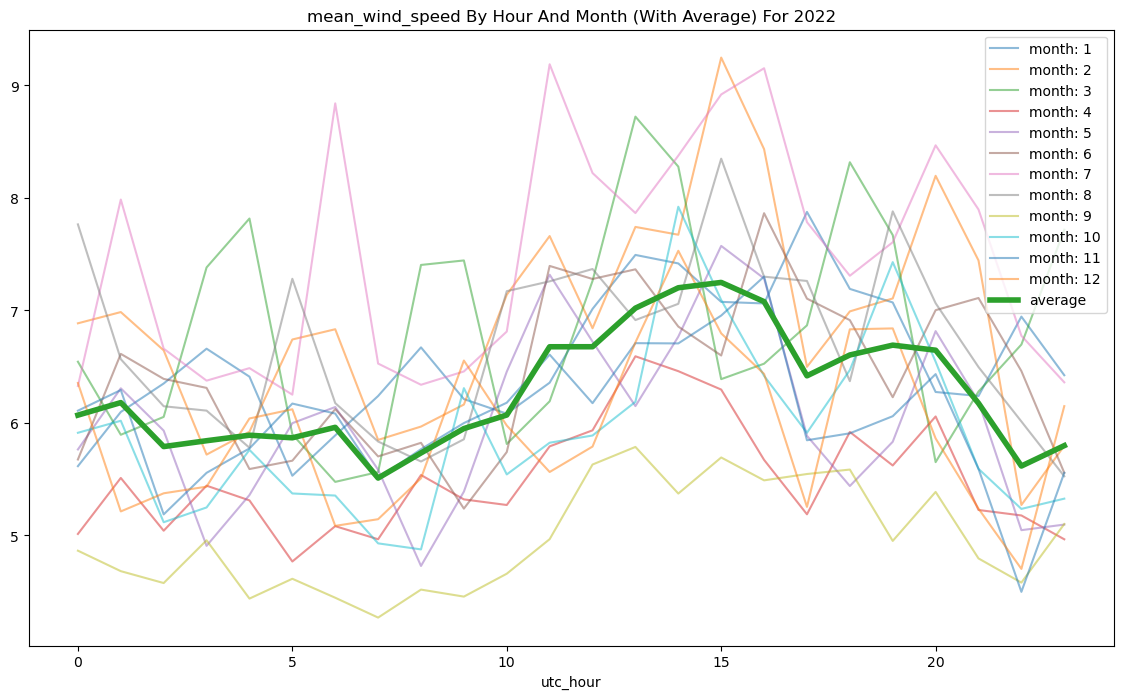

In [62]:
from datetime import datetime

grouped_col_name = f'mean_{dataset_name}'

hour_grouped = df.groupby(by=['utc_year', 'utc_month', 'utc_hour']).mean().mean(axis=1)
hour_grouped.name = grouped_col_name
hour_grouped = hour_grouped.reset_index()

fig, ax = plt.subplots(figsize=(14, 8))

for month in hour_grouped['utc_month'].unique():
    hour_grouped.loc[hour_grouped['utc_month'] == month].plot('utc_hour', grouped_col_name, ax=ax, label=f'month: {month}', alpha=0.5)

hour_grouped.groupby(by='utc_hour').agg({grouped_col_name: 'mean'}).reset_index().plot('utc_hour', grouped_col_name, ax=ax, label='average', linewidth=4)

ax.set_title(f'{grouped_col_name} By Hour And Month (With Average) For 2022')

https://en.wind-turbine-models.com/turbines/310-ge-general-electric-ge-2.5-120

In [63]:
from functools import partial

power_curve = {
    3: 25,
    3.5: 89, 
    4: 171, 
    4.5: 269, 
    5: 389,
    5.5: 533,
    6: 704,
    6.5: 906,
    7: 1136,
    7.5: 1400,
    8: 1674,
    8.5: 1934,
    9: 2160,
    9.5: 2316,
    10: 2416, 
    10.5: 2477,
    11: 2514,
    12: 2530, 
    12.5: 2530, 
    25: 2530,
}

power_curve_key = np.array(list(power_curve.keys()))
power_curve_val = np.array(list(power_curve.values()))

power_curve_function = partial(np.interp, xp=power_curve_key, fp=power_curve_val, left=0, right=0)

power_curve_function(3.8)

138.19999999999996

In [64]:
power_df = df.drop(columns=['utc_hour', 'utc_month', 'utc_year']).map(power_curve_function)

In [65]:
power_df['utc_hour'] = power_df.index.hour.astype(int)
power_df['utc_month'] = power_df.index.month.astype(int)
power_df['utc_year'] = power_df.index.year.astype(int)

Text(0.5, 1.0, 'mean_power_kW By Hour And Month (With Average) For 2022')

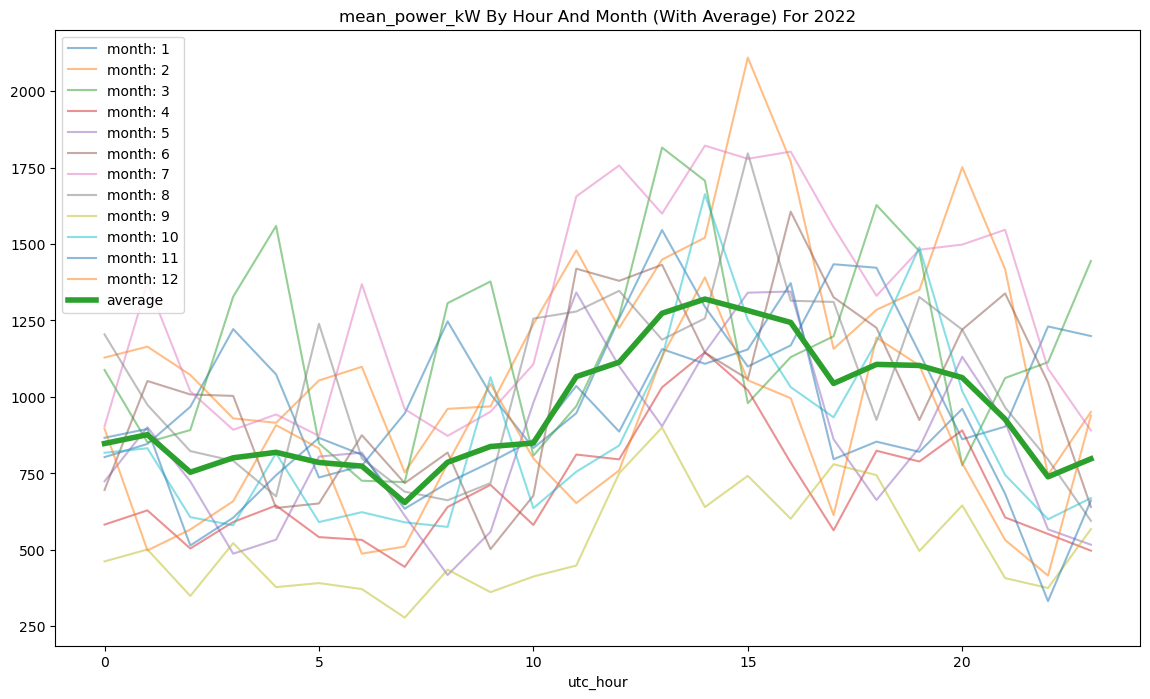

In [66]:
grouped_col_name = 'mean_power_kW'

hour_grouped = power_df.groupby(by=['utc_year', 'utc_month', 'utc_hour']).mean().mean(axis=1)
hour_grouped.name = grouped_col_name
hour_grouped = hour_grouped.reset_index()

fig, ax = plt.subplots(figsize=(14, 8))

for month in hour_grouped['utc_month'].unique():
    hour_grouped.loc[hour_grouped['utc_month'] == month].plot('utc_hour', grouped_col_name, ax=ax, label=f'month: {month}', alpha=0.5)

hour_grouped.groupby(by='utc_hour').agg({grouped_col_name: 'mean'}).reset_index().plot('utc_hour', grouped_col_name, ax=ax, label='average', linewidth=4)

ax.set_title(f'{grouped_col_name} By Hour And Month (With Average) For 2022')

In [67]:
power_df

,1440562,1441326,1459759,1460550,1460837,1460839,1460857,1460868,1461437,1461442,...,1511383,1511384,1512413,1514045,1515288,1516882,1517812,utc_hour,utc_month,utc_year
2020-01-01 00:00:00+00:00,425.184811,378.148876,764.911099,580.266410,474.390972,638.698725,257.675671,337.143742,0.000000,0.000000,...,103.423668,103.423668,131.443842,190.700619,257.675671,296.138608,1228.874349,0,1,2020
2020-01-01 05:00:00+00:00,1059.726913,1059.726913,1409.649094,1138.663055,902.961716,1059.726913,638.698725,697.131041,296.138608,159.464017,...,474.390972,474.390972,523.597132,580.266410,638.698725,697.131041,1503.277482,5,1,2020
2020-01-01 10:00:00+00:00,1059.726913,1059.726913,1228.874349,1059.726913,833.936407,981.133740,697.131041,764.911099,474.390972,378.148876,...,981.133740,902.961716,981.133740,981.133740,981.133740,1059.726913,1409.649094,10,1,2020
2020-01-01 15:00:00+00:00,697.131041,638.698725,833.936407,697.131041,697.131041,764.911099,580.266410,638.698725,425.184811,337.143742,...,378.148876,378.148876,378.148876,378.148876,378.148876,337.143742,764.911099,15,1,2020
2020-01-01 20:00:00+00:00,103.423668,78.388092,474.390972,337.143742,296.138608,425.184811,190.700619,224.188145,0.000000,0.000000,...,34.649283,0.000000,34.649283,56.518688,103.423668,103.423668,337.143742,20,1,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 00:00:00+00:00,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,...,2518.422588,2515.688912,2521.156264,2523.889939,2530.000000,2530.000000,2530.000000,0,12,2020
2020-12-31 05:00:00+00:00,2530.000000,2530.000000,2530.000000,2530.000000,2526.623615,2529.357290,2523.889939,2526.623615,2521.156264,2523.889939,...,2509.167971,2509.167971,2515.688912,2521.156264,2529.357290,2530.000000,2530.000000,5,12,2020
2020-12-31 10:00:00+00:00,2530.000000,2530.000000,2530.000000,2529.357290,2518.422588,2521.156264,2518.422588,2518.422588,2515.688912,2518.422588,...,2496.524721,2496.524721,2509.167971,2518.422588,2526.623615,2530.000000,2530.000000,10,12,2020
2020-12-31 15:00:00+00:00,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,...,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,15,12,2020


In [ ]:
lat_mapper = coord_df['lat'].to_dict()
lon_mapper = coord_df['lon'].to_dict()

In [68]:
power_df_melt = power_df.drop(columns=['utc_month', 'utc_year']).melt(id_vars='utc_hour')
power_df_melt['latitude'] = power_df_melt['variable'].map(lat_mapper)
power_df_melt['longitude'] = power_df_melt['variable'].map(lon_mapper)
power_df_melt

,utc_hour,variable,value
0,0,1440562,425.184811
1,5,1440562,1059.726913
2,10,1440562,1059.726913
3,15,1440562,697.131041
4,20,1440562,103.423668
...,...,...,...
834570,0,1517812,2530.000000
834571,5,1517812,2530.000000
834572,10,1517812,2530.000000
834573,15,1517812,2530.000000


In [78]:
wind_speed_df_melt = df.drop(columns=['utc_month', 'utc_year']).melt(id_vars='utc_hour')
wind_speed_df_melt['latitude'] = wind_speed_df_melt['variable'].map(lat_mapper)
wind_speed_df_melt['longitude'] = wind_speed_df_melt['variable'].map(lon_mapper)
wind_speed_df_melt

,utc_hour,variable,value,latitude,longitude
0,0,1440562,5.125642,18.09,-67.900002
1,5,1440562,6.834189,18.09,-67.900002
2,10,1440562,6.834189,18.09,-67.900002
3,15,1440562,5.979915,18.09,-67.900002
4,20,1440562,3.587949,18.09,-67.900002
...,...,...,...,...,...
834570,0,1517812,13.839233,18.33,-65.300003
834571,5,1517812,13.839233,18.33,-65.300003
834572,10,1517812,13.668378,18.33,-65.300003
834573,15,1517812,14.864361,18.33,-65.300003


In [79]:
total_sum_test_df = power_df_melt.groupby(by=['latitude', 'longitude']).agg({'value': 'sum'}).reset_index()
total_sum_test_df

,latitude,longitude,value
0,17.930000,-66.940002,1.674729e+06
1,17.930000,-66.180000,1.471438e+06
2,17.969999,-67.180000,2.123021e+06
3,17.969999,-67.139999,1.887324e+06
4,17.969999,-67.099998,1.753458e+06
...,...,...,...
470,18.490000,-67.059998,1.437777e+06
471,18.490000,-67.019997,1.380600e+06
472,18.490000,-66.980003,1.374257e+06
473,18.490000,-66.820000,1.366993e+06


In [73]:
total_mean_test_df = power_df_melt.groupby(by=['latitude', 'longitude']).agg({'value': 'mean'}).reset_index()
total_mean_test_df['capacity_factor'] = total_mean_test_df['value']/2.5e3
total_mean_test_df

,latitude,longitude,value,capacity_factor
0,17.930000,-66.940002,953.175062,0.381270
1,17.930000,-66.180000,837.471938,0.334989
2,17.969999,-67.180000,1208.321648,0.483329
3,17.969999,-67.139999,1074.174336,0.429670
4,17.969999,-67.099998,997.983962,0.399194
...,...,...,...,...
470,18.490000,-67.059998,818.313517,0.327325
471,18.490000,-67.019997,785.771417,0.314309
472,18.490000,-66.980003,782.161158,0.312864
473,18.490000,-66.820000,778.026780,0.311211


In [80]:
total_mean_test_df['capacity_factor'].quantile(0.96)

0.4611427971683735

<Axes: xlabel='longitude', ylabel='latitude'>

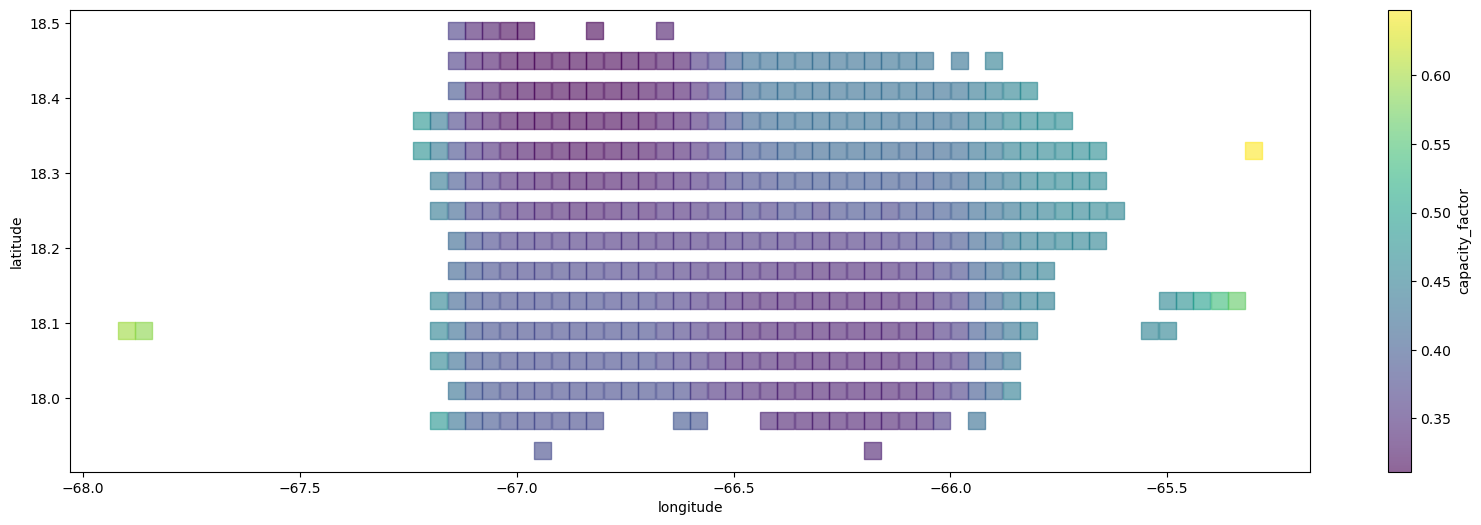

In [83]:
fig, ax = plt.subplots(figsize=(20, 6))

total_mean_test_df.plot.scatter('longitude', 'latitude', c='capacity_factor', s=150, alpha=0.6, ax=ax, marker='s')

In [84]:
total_mean_test_df

,latitude,longitude,value,capacity_factor
0,17.930000,-66.940002,953.175062,0.381270
1,17.930000,-66.180000,837.471938,0.334989
2,17.969999,-67.180000,1208.321648,0.483329
3,17.969999,-67.139999,1074.174336,0.429670
4,17.969999,-67.099998,997.983962,0.399194
...,...,...,...,...
470,18.490000,-67.059998,818.313517,0.327325
471,18.490000,-67.019997,785.771417,0.314309
472,18.490000,-66.980003,782.161158,0.312864
473,18.490000,-66.820000,778.026780,0.311211


In [88]:
power_df_melt

,utc_hour,variable,value,latitude,longitude
0,0,1440562,425.184811,18.09,-67.900002
1,5,1440562,1059.726913,18.09,-67.900002
2,10,1440562,1059.726913,18.09,-67.900002
3,15,1440562,697.131041,18.09,-67.900002
4,20,1440562,103.423668,18.09,-67.900002
...,...,...,...,...,...
834570,0,1517812,2530.000000,18.33,-65.300003
834571,5,1517812,2530.000000,18.33,-65.300003
834572,10,1517812,2530.000000,18.33,-65.300003
834573,15,1517812,2530.000000,18.33,-65.300003


In [167]:
power_values = power_df_melt.groupby(by=['utc_hour', 'latitude', 'longitude'])['value'].mean().reset_index()
power_values = power_values.rename(columns={'value': 'power_kW'})
power_values

,utc_hour,latitude,longitude,power_kW
0,0,17.930000,-66.940002,770.847384
1,0,17.930000,-66.180000,560.845196
2,0,17.969999,-67.180000,1087.007070
3,0,17.969999,-67.139999,919.298471
4,0,17.969999,-67.099998,829.815963
...,...,...,...,...
11395,23,18.490000,-67.059998,811.469933
11396,23,18.490000,-67.019997,775.455308
11397,23,18.490000,-66.980003,772.379923
11398,23,18.490000,-66.820000,770.753010


In [168]:
power_values.to_csv('../../data/generation_and_demand/wind_generation.csv')

In [158]:
lats = list(power_values.loc[power_values['utc_hour'] == 0, 'latitude'].unique())
lats.sort()
lats = np.array(lats)

lons = list(power_values.loc[power_values['utc_hour'] == 0, 'longitude'].unique())
lons.sort(reverse=True)
lons = np.array(lons)

hours = list(power_values['utc_hour'].unique())
hours.sort()
hours = np.array(hours)

hour_results = []
for utc_hour in hours:
    pivoted = power_values.loc[power_values['utc_hour'] == utc_hour].drop(columns=['utc_hour']).pivot(index='latitude', columns='longitude', values='value')
    hour_results.append(pivoted.loc[lats][lons].values)

In [159]:
power_results_array = np.array(hour_results)

In [163]:
power_results_array

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [160]:
power_results_array.shape

(24, 15, 50)

In [161]:
from PIL import Image

idx = 12

Image.fromarray((power_results_array[idx]/np.nanmax(power_results_array[idx]))*255).show()

In [162]:
summed = np.nansum(power_results_array, axis=0)
summed = summed/np.nanmax(summed)

Image.fromarray(summed*255).show()